# Análisis de datos postura: *Warrior*

### Calculo de los angulos medios de la postura para determinar el angulo ideal de la postura

## Posture data analysis: *Warrior*

#### Calculation of mean stance angles to determine the ideal stance angle

In [84]:
# Import libraries
import cv2
import math
import numpy as np
import pandas as pd
import mediapipe as mp
from matplotlib import pyplot as plt

### Definición de funciones de cálculo de ángulos

#### Definition of angle calculation functions

In [85]:
# Function for calculating the angles
def calculate_angle_coord(p_cood_list):
    """
    Calculate the angle formed by three coordinates in a 2D plane.

    Parameters:
        p_cood_list (list): A list containing three 2D coordinate points as numpy arrays.

    Returns:
        float: The angle in degrees between the lines connecting the first and second points
               and the second and third points. The angle is always in the range [0, 180].
    
    first_point = p_cood_list[0][*]
    mid_point = p_cood_list[1][*]
    last_point = p_cood_list[2][*]
    """
    radians = math.atan2(p_cood_list[2][1]-p_cood_list[1][1], p_cood_list[2][0]-p_cood_list[1][0]) - \
        math.atan2(p_cood_list[0][1]-p_cood_list[1][1], p_cood_list[0][0]-p_cood_list[1][0])
    angle = abs(radians*180.0/math.pi)

    if angle > 180.0:
        angle = 360-angle

    return angle

In [86]:
# Function to calculate the angles of the dataset

def angles_df(points, df, visibility):

    ang_points_coord= [[j+str(i)  for j in ['x', 'y', 'v']] for i in points]
    angle = []

    for j in range(df.shape[0]):
        l = []
        for i in ang_points_coord:
            if df[i[2]][j] > visibility:
                corr = (df[i[0]].iloc[j], df[i[1]].iloc[j])
                l.append(corr)
        if len(l) == 3:
            angle.append(int(calculate_angle_coord(l)))
    
    return angle

### Puntos para calcular el angulo

In [87]:
# Points for calculating the value angle of the middle of each tuple
#'warrior'
p_list = [(13, 11, 23),
        (14, 12, 24),
        (11, 13, 15),
        (16, 14, 12),
        (11, 23, 25),
        (12, 24, 26),
        (23, 25, 27),
        (24, 26, 28)]

![Alt text](..\interface\pages\Data\images_display\Landmarks.png)

### Representación de los puntos en imagen de la postura con su medición del ángulo

#### Representation of points in posture image with their angle measurement

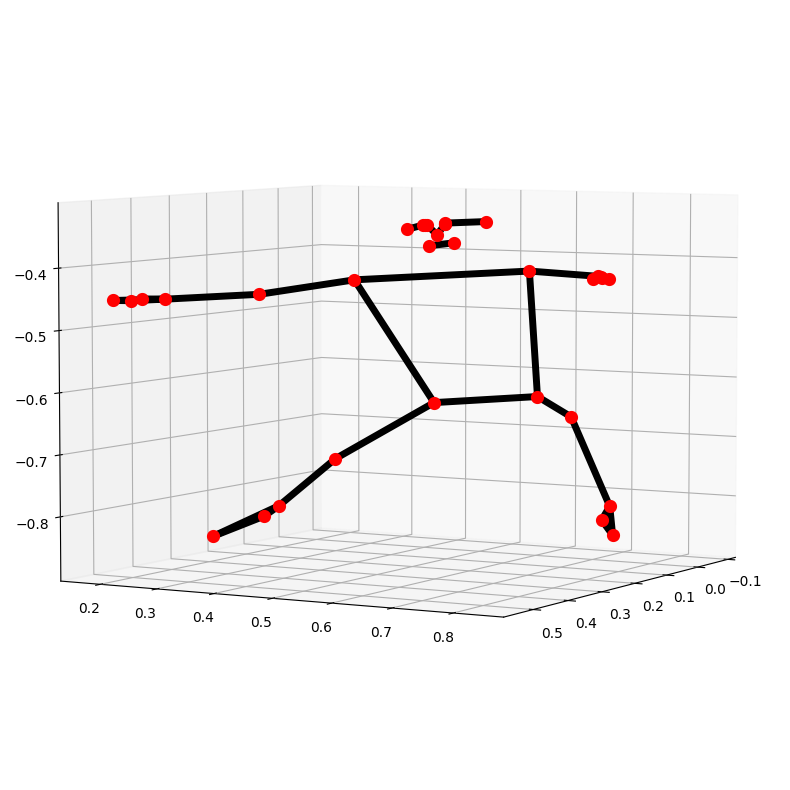

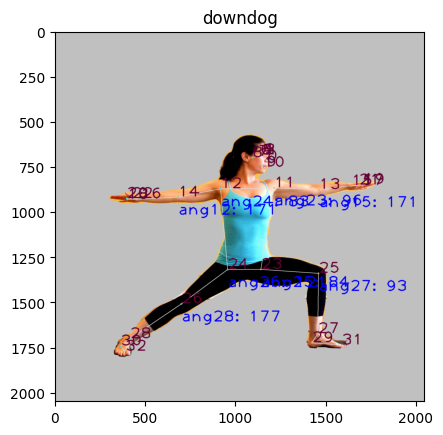

In [88]:
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_pose = mp.solutions.pose

# For static images:

path = '..\DATASET\TRAIN\\warrior\\00000.jpg'
#image = cv2.imread(path)

IMAGE_FILES = [path]
BG_COLOR = (192, 192, 192) # gray
with mp_pose.Pose(
    static_image_mode=True,
    enable_segmentation=True,
    min_detection_confidence=0.5) as pose:
  
  for idx, file in enumerate(IMAGE_FILES):
    image = cv2.imread(file)
    image_height, image_width, _ = image.shape
    # Convert the BGR image to RGB before processing.
    results = pose.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

    if not results.pose_landmarks:
      continue

    annotated_image = image.copy()
    # Draw segmentation on the image.
    # To improve segmentation around boundaries, consider applying a joint
    # bilateral filter to "results.segmentation_mask" with "image".
    condition = np.stack((results.segmentation_mask,) * 3, axis=-1) > 0.1
    bg_image = np.zeros(image.shape, dtype=np.uint8)
    bg_image[:] = BG_COLOR
    annotated_image = np.where(condition, annotated_image, bg_image)

    # Draw pose landmarks on the image.
    mp_drawing.draw_landmarks(
        annotated_image,
        results.pose_landmarks,
        mp_pose.POSE_CONNECTIONS,
        landmark_drawing_spec=mp_drawing_styles.get_default_pose_landmarks_style())
        
    landmrk_value = [l.value for l in mp_pose.PoseLandmark]

    text_size = int(round(np.linalg.norm(annotated_image.shape)*0.002,0))

    poses = results.pose_landmarks.landmark
    pose_row = list(np.array([[landmark.x, landmark.y, landmark.z, landmark.visibility] for landmark in poses]).flatten())

    for i in landmrk_value:
      if  results.pose_landmarks.landmark[i].visibility > 0.5 : 
        cv2.putText(annotated_image, str(i), (int((results.pose_landmarks.landmark[i].x)*annotated_image.shape[1]) , 
                                              int((results.pose_landmarks.landmark[i].y)*annotated_image.shape[0])),
                    cv2.FONT_HERSHEY_PLAIN, text_size, (50, 0, 100), text_size)
           
    
    for i in range(len(p_list)):
        p_cood_list = []
        midle_point = p_list[i][1]
        for p in p_list[i]:
            if results.pose_landmarks.landmark[p].visibility > 0.5:
                p_corrd = (results.pose_landmarks.landmark[p].x, results.pose_landmarks.landmark[p].y)
                p_cood_list.append(p_corrd)
            else:
                break

        try:
            angle = int(calculate_angle_coord(p_cood_list))
            cv2.putText(annotated_image, str(f'ang{p_list[i][2]}: {angle}'), (int((results.pose_landmarks.landmark[midle_point].x)*annotated_image.shape[1]) , 
                          100+int((results.pose_landmarks.landmark[midle_point].y)*annotated_image.shape[0])),
                          cv2.FONT_HERSHEY_PLAIN, text_size, (255,0,0), text_size)

        except:
            pass
      
   
    
    cv2.imwrite('images/annotated_image' + str(idx) + '.png', annotated_image)
    # Plot pose world landmarks.

mp_drawing.plot_landmarks(results.pose_landmarks, mp_pose.POSE_CONNECTIONS, elevation = 5, azimuth= 30)

image_pose = cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB)
plt.imshow(image_pose)
plt.title('downdog')
plt.show()

## Carga del dataset

### Load dataset

In [89]:
df_warrior_train = pd.read_csv('../coord_dataset_csv/df_warrior_train.csv')
df_warrior_test = pd.read_csv('../coord_dataset_csv/df_warrior_test.csv')
df_warrior = pd.concat([df_warrior_train, df_warrior_test],
                         ignore_index=True)
df_warrior

,class,path,x0,y0,z0,v0,x1,y1,z1,v1,...,z30,v30,x31,y31,z31,v31,x32,y32,z32,v32
0,warrior,DATASET/TRAIN/warrior\00000.jpg,0.573052,0.351157,-0.249836,0.999991,0.567133,0.335553,-0.215680,0.999980,...,-0.114747,0.988739,0.774529,0.848837,-0.072587,0.994987,0.189674,0.865255,-0.275244,0.998015
1,warrior,DATASET/TRAIN/warrior\00001.jpg,0.484442,0.154549,-0.309698,0.999857,0.496139,0.134806,-0.303896,0.998979,...,0.018561,0.987014,0.738432,0.968259,-0.190694,0.977414,0.259396,0.937513,-0.099410,0.978572
2,warrior,DATASET/TRAIN/warrior\00002.jpg,0.430756,0.344085,-0.165436,0.999984,0.441891,0.329612,-0.173110,0.999943,...,0.086803,0.992026,0.804327,0.867730,-0.232593,0.992542,0.228813,0.849506,-0.005299,0.986295
3,warrior,DATASET/TRAIN/warrior\00003.jpg,0.463907,0.128544,-0.191511,0.999783,0.478966,0.111549,-0.183811,0.998392,...,0.026783,0.992028,0.786402,0.976843,-0.167009,0.991430,0.251159,0.947926,-0.067149,0.989893
4,warrior,DATASET/TRAIN/warrior\00004.jpg,0.492190,0.126953,-0.180759,0.999979,0.502978,0.106739,-0.185714,0.999888,...,-0.031623,0.996196,0.786961,0.852702,0.071747,0.984940,0.206032,0.905196,-0.150242,0.995632
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
267,warrior,DATASET/TEST/warrior\00267.jpg,0.484089,0.203997,-0.111081,0.999938,0.491651,0.187007,-0.113273,0.999716,...,0.027554,0.988865,0.714938,0.962638,-0.165509,0.989565,0.314849,0.930008,-0.046122,0.984864
268,warrior,DATASET/TEST/warrior\00268.jpg,0.432160,0.198838,-0.387388,0.999968,0.444920,0.180878,-0.382607,0.999780,...,-0.089547,0.991252,0.825170,0.791324,0.084845,0.978573,0.180136,0.781066,-0.247969,0.989746
269,warrior,DATASET/TEST/warrior\00269.jpg,0.421851,0.333012,-0.195190,0.999943,0.426797,0.317650,-0.201206,0.999601,...,0.083238,0.995784,0.654345,0.939613,-0.251115,0.997821,0.275559,0.888648,0.037844,0.990626
270,warrior,DATASET/TEST/warrior\00270.jpg,0.541960,0.253691,-0.311029,0.999986,0.536933,0.238940,-0.286740,0.999945,...,0.058292,0.959162,0.698355,0.890077,-0.131697,0.993748,0.299599,0.913692,-0.088099,0.993308


warrior


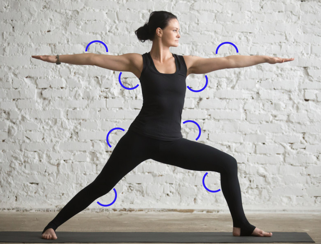

warrior_inv


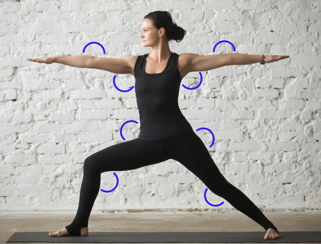

In [90]:
from PIL import Image 
tree_im = Image.open(r"../interface/pages/Data/images_display/warrior.png") 
tree_im_inv = Image.open(r"../interface/pages/Data/images_display/warrior_inv.png") 
scale = 0.3
print('warrior')
display(tree_im.resize(( int(tree_im.width * scale), int(tree_im.height * scale))))
print('warrior_inv')
display(tree_im_inv.resize(( int(tree_im_inv.width * scale), int(tree_im_inv.height * scale))))

In [91]:
# Minimum visibility
visibility = 0.8

### Análisis de los ángulos en cada punto

#### Analysis of the angles at each point

In [92]:
# Points on the rigth side
ang11_points  = [13,11,23]
ang12_points  = [14,12,24]
ang13_points  = [11,13,15]
ang14_points  = [16,14,12]
ang23_points  = [11,23,25]
ang24_points  = [12,24,26]
ang25_points  = [23,25,27]
ang26_points  = [24,26,28]

#### Punto 11

##### Point 11

In [93]:
ang11 = pd.DataFrame({'ang11':angles_df(ang11_points, df_warrior, visibility)})
ang11.describe()

,ang11
count,270.000000
mean,95.696296
std,9.273437
min,44.000000
25%,90.000000
50%,96.000000
75%,102.000000
max,122.000000


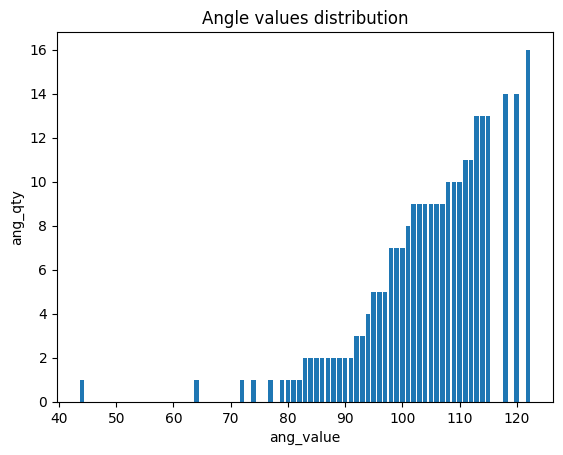

In [94]:
plt.bar(ang11['ang11'].sort_values().unique(), ang11['ang11'].value_counts().sort_values())
plt.xlabel("ang_value"), plt.ylabel("ang_qty"), plt.title('Angle values distribution')
plt.show()

#### Punto 12

##### Point 12

In [95]:
ang12 = pd.DataFrame({'ang12':angles_df(ang12_points, df_warrior, visibility)})
ang12.describe()

,ang12
count,271.000000
mean,97.970480
std,11.112849
min,44.000000
25%,92.000000
50%,98.000000
75%,103.500000
max,162.000000


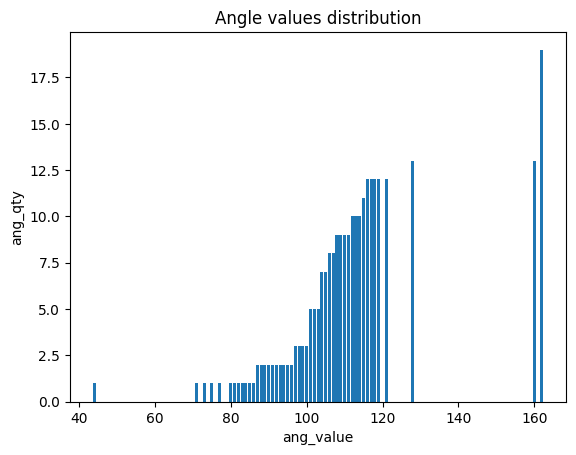

In [96]:
plt.bar(ang12['ang12'].sort_values().unique(), ang12['ang12'].value_counts().sort_values())
plt.xlabel("ang_value"), plt.ylabel("ang_qty"), plt.title('Angle values distribution')
plt.show()

#### Punto 13

##### Point 13

In [97]:
ang13 = pd.DataFrame({'ang13':angles_df(ang13_points, df_warrior, visibility)})
ang13.describe()

,ang13
count,270.000000
mean,172.922222
std,5.723287
min,147.000000
25%,170.000000
50%,174.000000
75%,177.000000
max,179.000000


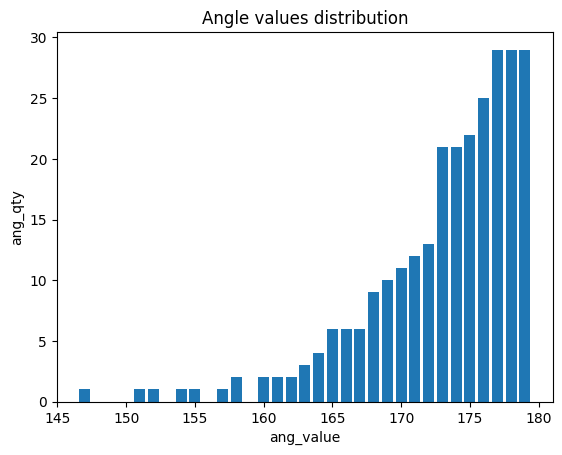

In [98]:
plt.bar(ang13['ang13'].sort_values().unique(), ang13['ang13'].value_counts().sort_values())
plt.xlabel("ang_value"), plt.ylabel("ang_qty"), plt.title('Angle values distribution')
plt.show()

#### Punto 14

##### Point 14

In [99]:
ang14 = pd.DataFrame({'ang14':angles_df(ang14_points, df_warrior, visibility)})
ang14.describe()

,ang14
count,269.000000
mean,171.973978
std,7.193181
min,109.000000
25%,170.000000
50%,173.000000
75%,176.000000
max,179.000000


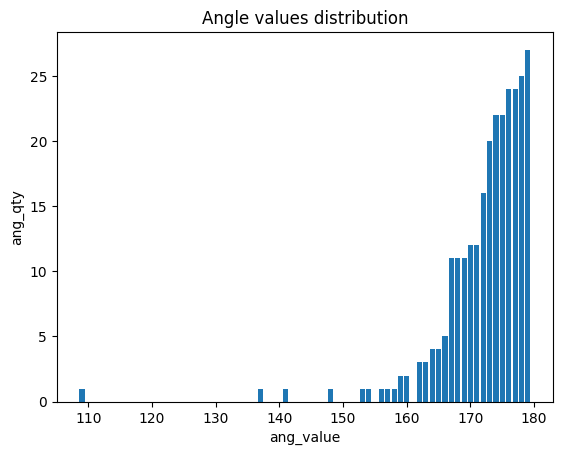

In [100]:
plt.bar(ang14['ang14'].sort_values().unique(), ang14['ang14'].value_counts().sort_values())
plt.xlabel("ang_value"), plt.ylabel("ang_qty"), plt.title('Angle values distribution')
plt.show()

#### Punto 23

##### Point 23

In [101]:
ang23_all = pd.DataFrame({'ang23':angles_df(ang23_points, df_warrior, visibility)})
ang23_all.count()

ang23    272
dtype: int64

In [102]:
ang23_all['ang23'].sort_values().unique()

array([ 71,  72,  84,  85,  86,  87,  88,  89,  90,  92,  93,  94,  95,
        96,  97,  98,  99, 100, 101, 102, 103, 104, 107, 108, 109, 110,
       111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123,
       124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136,
       137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149,
       150, 151, 152, 154, 155, 156, 158, 169], dtype=int64)

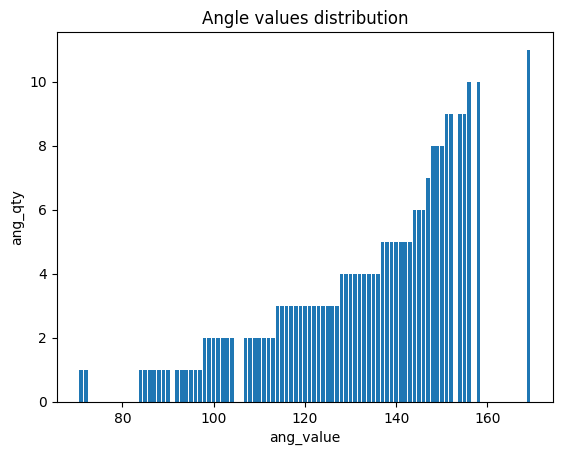

In [103]:
plt.bar(ang23_all['ang23'].sort_values().unique(), ang23_all['ang23'].value_counts().sort_values())
plt.xlabel("ang_value"), plt.ylabel("ang_qty"), plt.title('Angle values distribution')
plt.show()

In [104]:
ang23 = ang23_all[ang23_all['ang23'] < 115]
ang23_inv = ang23_all[ang23_all['ang23'] > 115]

ang23.describe()

,ang23
count,82.000000
mean,98.500000
std,10.197131
min,71.000000
25%,92.000000
50%,99.000000
75%,107.000000
max,114.000000


In [105]:
ang23_inv.describe()

,ang23
count,187.000000
mean,135.791444
std,9.205791
min,116.000000
25%,128.500000
50%,136.000000
75%,142.000000
max,169.000000


#### Punto 24

##### Point 24

In [106]:
ang24_all = pd.DataFrame({'ang24':angles_df(ang24_points, df_warrior, visibility)})
ang24_all.count()

ang24    272
dtype: int64

In [107]:
ang24_all['ang24'].sort_values().unique()

array([ 55,  74,  75,  76,  77,  78,  79,  81,  82,  83,  84,  85,  86,
        87,  89,  90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100,
       101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113,
       114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126,
       127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139,
       140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 153,
       155, 157, 161], dtype=int64)

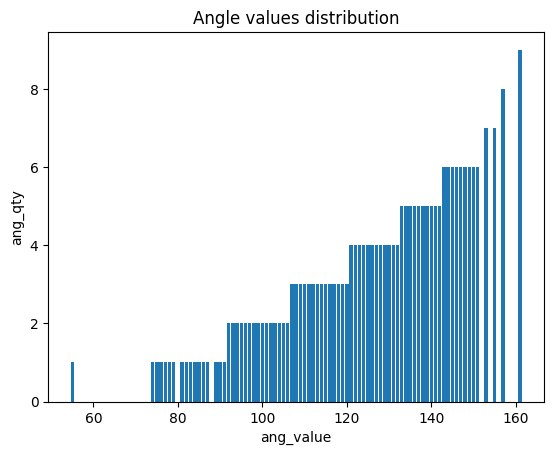

In [108]:
plt.bar(ang24_all['ang24'].sort_values().unique(), ang24_all['ang24'].value_counts().sort_values())
plt.xlabel("ang_value"), plt.ylabel("ang_qty"), plt.title('Angle values distribution')
plt.show()

In [109]:
ang24 = ang24_all[ang24_all['ang24'] > 120]
ang24_inv = ang24_all[ang24_all['ang24'] < 120]

ang24.describe()

,ang24
count,105.000000
mean,136.209524
std,10.619915
min,121.000000
25%,128.000000
50%,135.000000
75%,143.000000
max,161.000000


In [110]:
ang24_inv.describe()

,ang24
count,166.000000
mean,100.554217
std,12.253141
min,55.000000
25%,92.000000
50%,102.000000
75%,110.750000
max,119.000000


#### Punto 25

##### Point 25

In [111]:
ang25_all = pd.DataFrame({'ang25':angles_df(ang25_points, df_warrior, visibility)})
ang25_all.count()

ang25    271
dtype: int64

In [112]:
ang25_all['ang25'].sort_values().unique()

array([ 67,  86,  87,  93,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       118, 119, 123, 125, 127, 128, 131, 133, 134, 135, 136, 137, 139,
       141, 147, 150, 151, 161, 164, 165, 169, 170, 171, 172, 173, 174,
       175, 176, 177, 178, 179], dtype=int64)

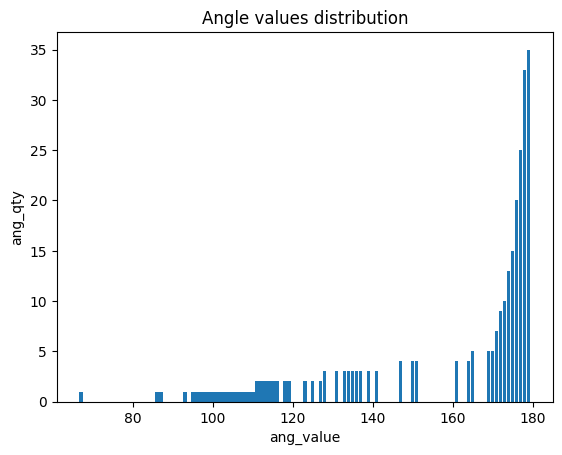

In [113]:
plt.bar(ang25_all['ang25'].sort_values().unique(), ang25_all['ang25'].value_counts().sort_values())
plt.xlabel("ang_value"), plt.ylabel("ang_qty"), plt.title('Angle values distribution')
plt.show()

In [114]:
ang25 = ang25_all[ang25_all['ang25'] < 120]
ang25_inv = ang25_all[ang25_all['ang25'] > 120]
ang25.describe()

,ang25
count,71.000000
mean,104.464789
std,8.590412
min,67.000000
25%,99.000000
50%,105.000000
75%,110.000000
max,119.000000


In [115]:
ang25_inv.describe()

,ang25
count,200.000000
mean,170.785000
std,14.011079
min,123.000000
25%,173.000000
50%,176.000000
75%,178.000000
max,179.000000


#### Punto 26

##### Point 26

In [116]:
ang26_all = pd.DataFrame({'ang26':angles_df(ang26_points, df_warrior, visibility)})
ang26_all.count()

ang26    271
dtype: int64

In [117]:
ang26_all['ang26'].sort_values().unique()

array([ 68,  84,  85,  86,  87,  88,  90,  92,  93,  94,  95,  96,  97,
        98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110,
       111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123,
       124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136,
       137, 139, 140, 142, 143, 145, 155, 166, 168, 169, 170, 171, 172,
       173, 174, 175, 176, 177, 178, 179], dtype=int64)

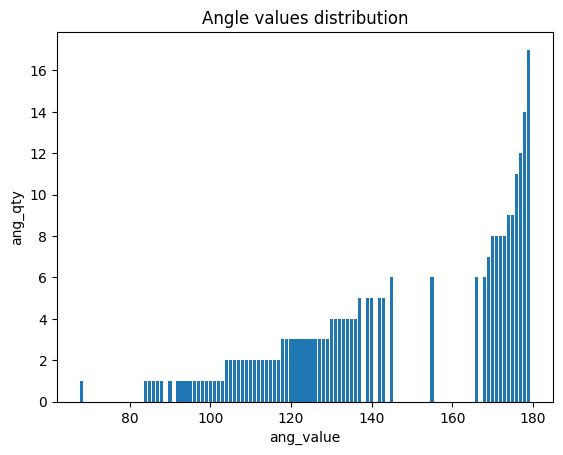

In [118]:
plt.bar(ang26_all['ang26'].sort_values().unique(), ang26_all['ang26'].value_counts().sort_values())
plt.xlabel("ang_value"), plt.ylabel("ang_qty"), plt.title('Angle values distribution')
plt.show()

In [119]:
ang26 = ang26_all[ang26_all['ang26'] > 162]
ang26_inv = ang26_all[ang26_all['ang26'] < 162]

ang26.describe()

,ang26
count,91.000000
mean,175.054945
std,3.060002
min,166.000000
25%,173.500000
50%,175.000000
75%,178.000000
max,179.000000


In [120]:
ang26_inv.describe()

,ang26
count,180.000000
mean,112.794444
std,13.789194
min,68.000000
25%,103.000000
50%,113.000000
75%,121.000000
max,155.000000


## Valores medios de los ángulos para cada punto

### Average values of the angles for each point

In [83]:
results = pd.DataFrame({'ang: 11' : (int(ang11.mean().item()), int(ang11.mean().item())),
                        'ang: 12' : (int(ang12.mean().item()), int(ang12.mean().item())),
                        'ang: 13' : (int(ang13.mean().item()), int(ang13.mean().item())),
                        'ang: 14' : (int(ang14.mean().item()), int(ang14.mean().item())),
                        'ang: 23' : (int(ang23.mean().item()), int(ang23_inv.mean().item())), 
                        'ang: 24' : (int(ang24.mean().item()), int(ang24_inv.mean().item())), 
                        'ang: 25' : (int(ang25.mean().item()), int(ang25_inv.mean().item())),
                        'ang: 26' : (int(ang26.mean().item()), int(ang26_inv.mean().item()))},
                        index=['tree', 'tree_inv'])
results

,ang: 11,ang: 12,ang: 13,ang: 14,ang: 23,ang: 24,ang: 25,ang: 26
tree,95,97,172,171,98,136,104,175
tree_inv,95,97,172,171,135,100,170,112
